# Assignment 2: Stereo Camera System

**Student:** Do Duc Quan

**Course:** ENG301 Computer Vision

**Instructor:** Prof. Phung Manh Duong

<p float = "center">
    <img src="utils/img/Image.jpg" width = "320">
    <img src="utils/img/Disparity.jpg" width = "320">
    <img src="utils/img/PointCloud01.png" width = "320">
</p>

In this assignment, we will write a program to compute the depth information from 2 stereo systems: one with 1 camera and another with 2 uncalibrated cameras. We also write the calculated distance to the input image and export it together with the depth map to a point cloud file.

This is the overall approach:

- Load and pre-process the images
- Compute disparity map
- Compute depth map
- Convert depth map to point cloud
- Display depth with warning

Let's get the ball rolling.

In [1]:
# Import libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Import utilities
from utils.depth import return_depth, px_cm_ratio, depth_to_ply, display_individual_depth
from utils.disparity import return_disparity, disparity_helper, calculate_disparity_dim, combine_disparity, return_ranges
from utils.rectify import rectify, undistort
from utils.helpers import normalize, merge_range, draw_text

## A. Calibrated Cameras
### 1. Load and Preprocess

First, as usual, we will import the images. We will choose the images where the object is located at 50cm further from the cameras system. We then convert them into back and white image.

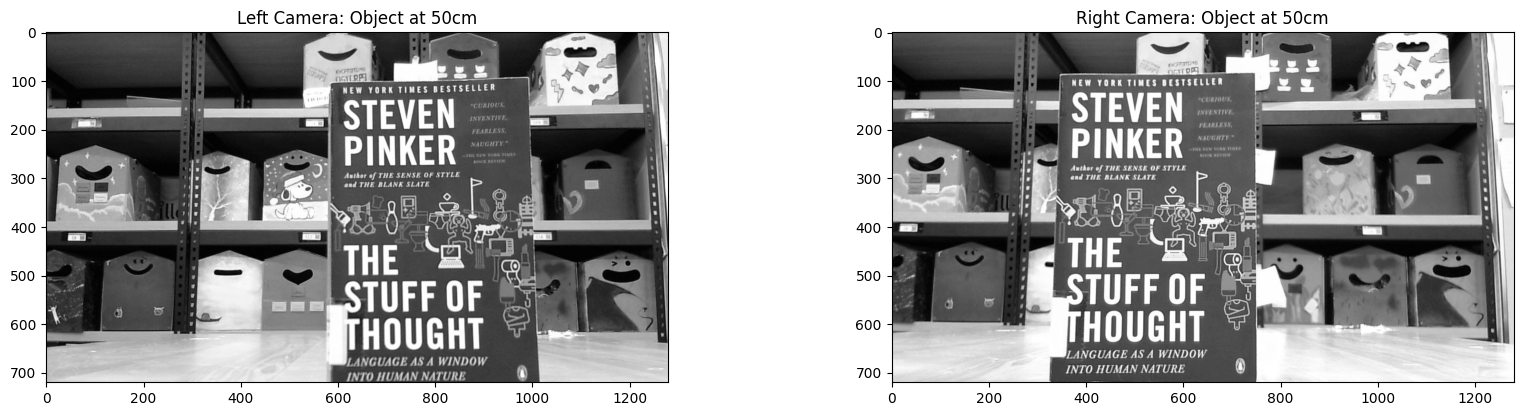

In [2]:
# Import images
imgL = cv.imread('assets/stereo/position2/left.jpg')
imgR = cv.imread('assets/stereo/position2/right.jpg')

# Convert to grayscale
gray_imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
gray_imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(gray_imgL, cmap = "gray"); ax.set_title('Left Camera: Object at 50cm')
ax = fig.add_subplot(2, 2, 2); plt.imshow(gray_imgR, cmap = "gray"); ax.set_title('Right Camera: Object at 50cm');

Since this system is stereo, we will set `stereo = True`. This is for later methods to decide whether to use parameters for stereo system or mono system.

In [3]:
# Params for stereo/mono. Set True if using stereo, else False.
stereo = True

### 2. Compute disparity map

Having imported the object's image captured by left and right camera, we now calculate its disparity.

First, let's resize the input into 3 different dimensions: `(1280, 720)`, `(640, 360)`, and `(320, 180)`. The reason behind this action is that we want to have the object shape's disparity by resizing to a very small dimension. And, for object's details, the large dimension images will do the work. The mid dimension is for neutrality between two dimensions. The code for resize is: 
```
resized_imgL, resized_imgR = cv.resize(imgL, dim), cv.resize(imgR, dim)
```

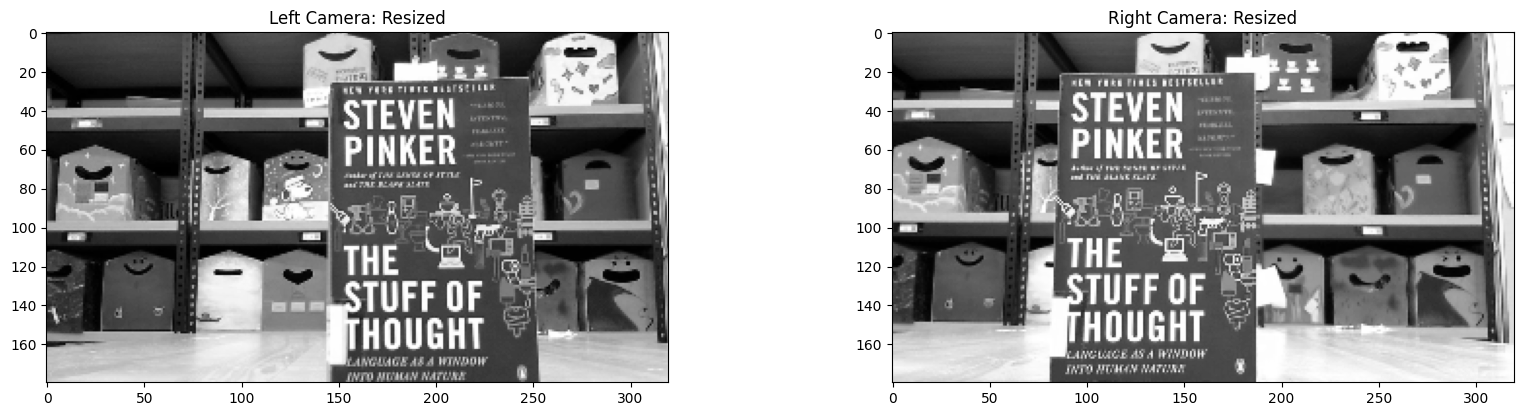

In [4]:
## Sample code for 180p

sample_resized_imgL = cv.resize(gray_imgL, (320, 180))
sample_resized_imgR = cv.resize(gray_imgR, (320, 180))

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(sample_resized_imgL, cmap = "gray"); ax.set_title('Left Camera: Resized')
ax = fig.add_subplot(2, 2, 2); plt.imshow(sample_resized_imgR, cmap = "gray"); ax.set_title('Right Camera: Resized');

Then, for each dimension, we will perform Gaussian blur and use the blurred image with `StereoSGBM_create()` and `stereo.compute()` to calculate corresponding disparity map. 

 - The parameters for StereoSGBM of each dimension is as below. For large dimension, we will use small kernel size, large disparity value, and large block size. For small dimension, a large kernel size, small disparity value and small block size will be used.
    
     - 720p: `{"kernel": 3, "block": 20, "min_disparity": 5, "disparity": 8}`
     - 360: `{"kernel": 5, "block": 18, "min_disparity": 0, "disparity": 8}`
     - 180p: `{"kernel": 7, "block": 15, "min_disparity": 0, "disparity": 5}`

  - The code for calculate disparity is as follow:
    ```
    # Blur images to remove noises
    blur_imgL = cv.GaussianBlur(imgL, (kernel, kernel), 0)
    blur_imgR = cv.GaussianBlur(imgR, (kernel, kernel), 0)

    # Calculate disparity
    stereo = cv.StereoSGBM_create(minDisparity = 16 * min_dispar, numDisparities = 16 * dispar,
                              blockSize = block, speckleRange = 2,
                              P1 = 8 * 3 * kernel ** 2, P2 = 32 * 3 * kernel ** 2)
    disparity = stereo.compute(blur_imgL, blur_imgR)
    ```

Min: -16 Max: 1264 Mean: 348.5060763888889


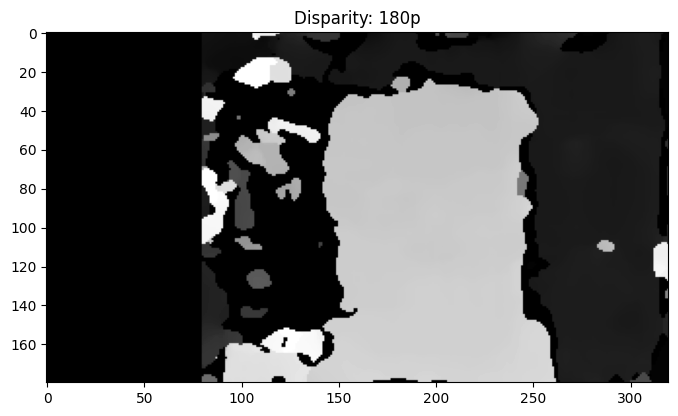

In [5]:
## Sample code for 180p

# Blur images to remove noises
sample_blur_imgL = cv.GaussianBlur(sample_resized_imgL, (7, 7), 0)
sample_blur_imgR = cv.GaussianBlur(sample_resized_imgR, (7, 7), 0)

# Calculate disparity
sample_stereo = cv.StereoSGBM_create(minDisparity = 16 * 0, numDisparities = 16 * 5,
                              blockSize = 18, speckleRange = 2,
                              P1 = 8 * 3 * 7 ** 2, P2 = 32 * 3 * 7 ** 2)
sample_disparity = sample_stereo.compute(sample_blur_imgL, sample_blur_imgR)

# Display disparity
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(sample_disparity, cmap = "gray"); ax.set_title('Disparity: 180p')
print("Min:", sample_disparity.min(), "Max:", sample_disparity.max(), "Mean:", sample_disparity.mean())

Since the disparity correlates with the chosen value for `min_dispar` and `num_dispar` and each dimension has different values, their disparity map will have different range. Therefore, we scale all disparity map to the same ground using the following scaling method:

```scaled = (disparity / (16 ** 2) - min_dispar) / num_dispar```

Min: -0.0125 Max: 0.9875 Mean: 0.27227037217881944


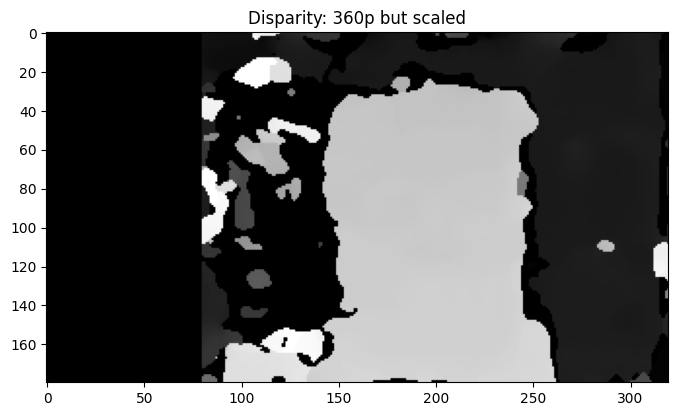

In [6]:
## Sample code for 180p
sample_scaled = (sample_disparity / (16 ** 2) - 0) / 5

# Display disparity map
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(sample_scaled, cmap = "gray"); ax.set_title('Disparity: 360p but scaled')
print("Min:", sample_scaled.min(), "Max:", sample_scaled.max(), "Mean:", sample_scaled.mean())

It is clearly that the displayed disparity map is unchanged. This is because Matplotlib automatically normalize the value range to `[0,255]` for visualization. However, when looking at min, max, and mean, these values are significantly smaller.

We then do the same thing for other dimensions. For reusable purpose, we wrap it in a method called `return_disparity()` that can be found at [disparity.py](utils/disparity.py).

In [7]:
# Calculate disparity
hi, mid, low = return_disparity(gray_imgL, gray_imgR)

Having different disparity maps, we will try to combine them into 1 map.  We use the 180p's map as the main references. We want this map to retain all "close" object and we only add the details of background objects. This is because that the closer distance, the bigger the object and the fewer objects appear in our images.

After trials and  errors, we obtain that the disparity range for close objects are from `0.25` onwards, and that for far objects are `~0` to `0.25`. Having the range for close objects, we can also detect different objects in that range. We can do so using a simple histogram with a threshold as follow:

```
# Make histogram
dispar_hist = np.histogram(dispar_safe, bins, (min_dispar, max_dispar))

# Return all ranges that has intensity larger then the threshold
dispar_range = []
threshold = 50000  # Since we observe that the object in the image is 200 x 600 = 120000px
dispar_range.append([bin_size * i, bin_size * (i + 1)]) if dispar_hist[0][i] > threshold for i in range(0, bins)
```

Having said, let's combine the disparity map, get objects' range and display it out.

Text(0.5, 1.0, 'Combination')

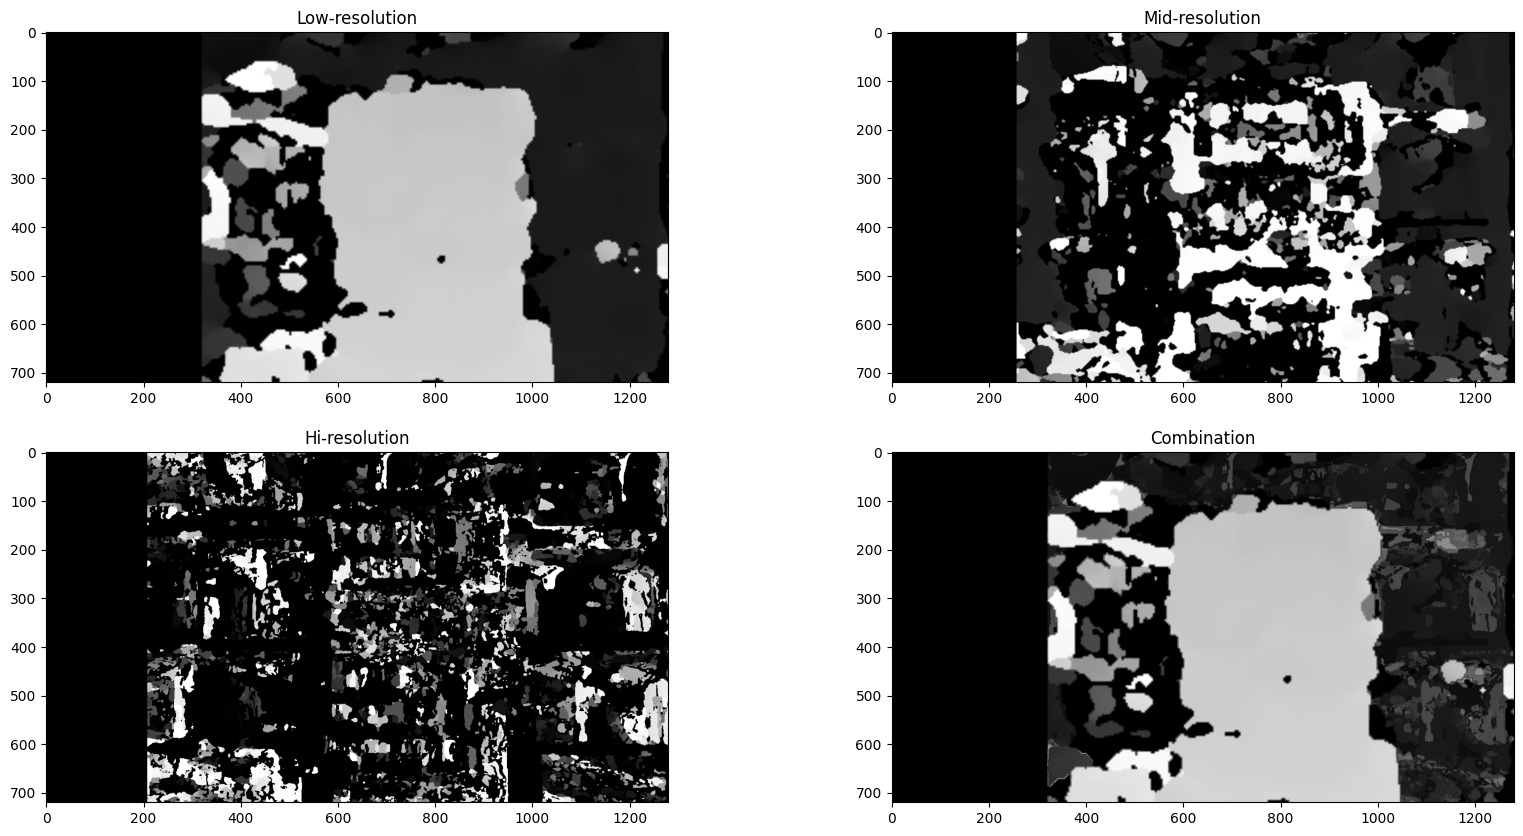

In [8]:
# Specify the dectected ranges
range_low = return_ranges(low, 0.25, 1.25, 10, 50000)
range_mid_high = merge_range(return_ranges(low, 0.05, 0.25, 2, 50000))

# Combine
combined = combine_disparity(gray_imgL.shape[::-1], low, mid, hi, range_mid_high)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(low, cmap = "gray"); ax.set_title('Low-resolution')
ax = fig.add_subplot(2, 2, 2); plt.imshow(mid, cmap = "gray"); ax.set_title('Mid-resolution')
ax = fig.add_subplot(2, 2, 3); plt.imshow(hi, cmap = "gray"); ax.set_title('Hi-resolution')
ax = fig.add_subplot(2, 2, 4); plt.imshow(combined, cmap = "gray"); ax.set_title('Combination')

We think that the overall result is good and as expected. The main object's region is remained and other regions are combined with other dimension to add details to the map.

### 3. Calculate and export depth map

Having the disparity map `(px/px)` (as we have scaled it previously), we can calculate the distance from the camera system to the object.

The equation is: ``` depth (cm) = BASELINE (cm) * FOCAL_LENGTH (cm) / disparity (dimensionless)```
    
where `BASELINE = 9` and `FOCAL_LENGTH = 0.41...` (obtained through calibration [here](outputs/left.yaml)).

Since disparity map is dimensionless, we must convert it back to cm for calculation. However, we do not know the neccessary value to do so. Therefore, we have a dedicated program called [finetuning.py](utils/finetuning.py) that use the same approach as above to log out all depth value. Then, we measure the depth in real-life and use it as the ground truth. Those values are as follow:
- Ground truth: `[50, 70, 100]`
- Estimation value: `[4.72974624, 6.67173753, 9.98931149]`

(It seems like we just have to multiply our estimation values with `10`).

With these values and labels, our problem now becomes a supervised problem that can be easily solved using a simple linear regression program. We wrap it in a function called `px_cm_ratio()`, which can be found at [depth.py](utils/depth.py) along with `return_depth()`.

In [9]:
# Calculate depth map
depth_map = return_depth(combined, stereo)
depth_map_cm = px_cm_ratio(depth_map, stereo, False)

Then, we combine the depth map with the inputed left image to a point cloud file. We initalize the point cloud file with zeros, mask out-of-bound region from the depth map, and add value from depth matrix to point cloud matrix. Since our point cloud is just for visualization purposes, we will use `depth_map` instead of `depth_map_cm` for lower value range.

In [10]:
# Initialize point cloud
height, width = depth_map.shape
pcd = np.zeros((height, width, 3))

# Remove out-of-bound area
mask = cv.inRange(depth_map, 0, 200)
depth_safe = cv.bitwise_and(depth_map, depth_map, depth_map, mask = mask)

for i in range(height):
    for j in range(width):
        z = depth_safe[i][j]
        pcd[i][j] = [i, j, z]

Finally we write the point cloud matrix and the image to a `.ply` file. Since my computer cannot install `open3d`, I must use other option, which is [pyntcloud](https://pypi.org/project/pyntcloud/). The writing algorithm is as follow:

```
# Create a dict of data
data = {'x': pcd[:, 0], 'y': pcd[:, 1], 'z': pcd[:, 2], 
        'red': img[:, 2], 'green': img[:, 1], 'blue': img[:, 0]}

# Build a cloud
cloud = PyntCloud(pd.DataFrame(data))

# Write .ply file
cloud.to_file('outputs/' + name + '.ply')
```

For reusability, I wrap the code into a method called `depth_to_ply()` that can you can find on [depth.py](utils/depth.py). It will write a Point cloud file to [outputs/stereo_position2_left.ply](outputs/stereo_position2_left.ply).

In [11]:
# Write point cloud file     
_, data = depth_to_ply(imgL, pcd, name = "notebook_stereo_pts")

Since `pyntcloud` does not support inline visualization, you can open that file yourself to see the result. For demonstration purpose, I have screenshot the point cloud file at some angle and will show you as below:

<p float = "center">
    <img src="utils/img/PointCloud01.png" width = "320">
    <img src="utils/img/PointCloud02.png" width = "320">
    <img src="utils/img/PointCloud03.png" width = "320">
</p>

I believe I get a pretty good result here since that the object is segmented and float a little bit from the background where `depth = 0`. And we also get the depth map of object behind, which is also good since we have the depth of large regions (e.g. the green box).

One disadvantage one may say is that we have some noises. However, this is exactly how I want my depth map to be since that noises are the results of combining with the 720p's disparity map. If one does not like it, they can simply use the 360p's disparity map and do not combine with other maps.

### 4. Show disparity, depth and display warning

Having both the disparity and depth value, let's write this value onto the screen. Since we have had the peaked value in close distances, which are representatives of the object, we will use them to identify where our object is located at using `cv.findContours` – a simple contour detection. Then, we take the average of that region's depth values and use it as final distance value for that object.

Once again, we also wrapped into a method called `display_individual_depth()` at [depth.py](utils/depth.py). Its contents is as below:

```
# Remove out-of-bound area
mask = cv.inRange(dispar_map, dispar_range[0], dispar_range[1])
dispar_safe = cv.bitwise_and(dispar_map, dispar_map, mask = mask)
    
# Calculate depth map
depth_map = px_cm_ratio(return_depth(dispar_safe, stereo), stereo, False)
    
# Contour detection 
contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key = cv.contourArea, reverse = True)

# Check if detected contour is significantly large (to avoid multiple tiny regions)
x, y, w, h = cv.boundingRect(cnts[0])

# Finding average depth of region represented by the largest contour 
new_mask = np.zeros_like(mask)
cv.drawContours(new_mask, cnts, 0, (255), -1)

# Calculating the average depth of the object closer than the safe distance
depth_mean, _ = cv.meanStdDev(depth_map, mask = new_mask)
```

Text(0.5, 1.0, 'Image')

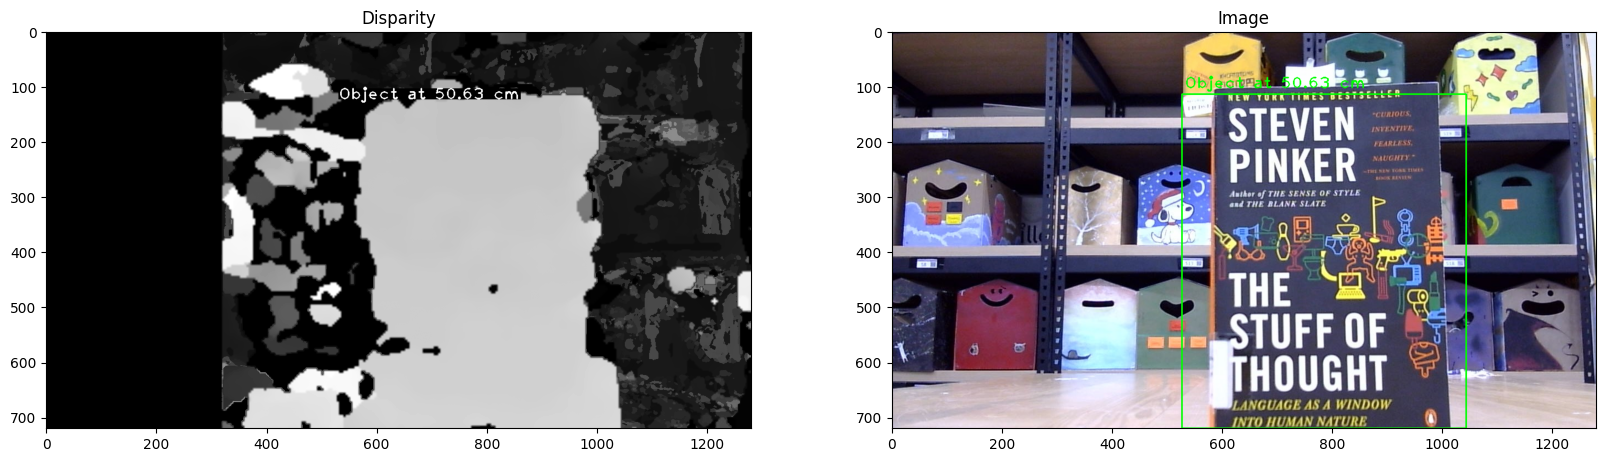

In [12]:
# Create canvas for visualization
canvas_dispar = normalize(combined)
canvas_img = imgL.copy()

# Show depth and warning text
for dispar_range in range_low:
    x_left, y_top, x_right, y_bot, value = display_individual_depth(combined, dispar_range, stereo)
    
    # Put text on disparity image
    draw_text(canvas_dispar, "Object at %.2f cm" % value, (x_left + 5, y_top - 10))
    
    # Put text and detected box on image imae
    cv.putText(canvas_img, "Object at %.2f cm" % value,
               (x_left + 5, y_top - 10), 1, 2, (0, 255, 0), 2, 2)
    cv.rectangle(canvas_img, (x_left, y_top), (x_right, y_bot), (0, 255, 0), 2)
    
    # Put warning text
    if value < 50:
        draw_text(canvas_dispar, "WARNING: Object closer than 50cm!", (50, 50))
        cv.putText(canvas_img, "WARNING: Object closer than 50cm!",
                   (50, 50), 1, 2, (0, 0, 255), 2, 2)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 2, 1); plt.imshow(canvas_dispar, cmap = "gray"); ax.set_title('Disparity')
ax = fig.add_subplot(1, 2, 2); plt.imshow(canvas_img[:, :, ::-1]); ax.set_title('Image')

As we measured in real-life, the distance is 50cm. With the detection of 51.16cm, the algorithm's result is really close to the truth value since the error is ±1.

## B. Uncalibrated Camera
### 1. Load and Preprocess

We use slightly the same codes as above with only 1 modification. Instead of using the input images, we must undistort them with a retification matrix to make sure that the points in both images are located in the same line.
- First, we use SIFT detector to find good unique points and calculate transformation matrix from those points
- Then, we use `cv.decomposeHomographyMat()` to decompose transformation matrix into translation from left onto right and rotation from right to left.
- After that, `cv.stereoRectify()` is used to export rectify and projection matrices.
- Finally, with the instrinsic, coeffient distortion, rectify, and projection matrices, we use `cv.initUndistortRectifyMap()` and `cv.remap()` to undistort the image.

For details, you can go to [rectify.py](utils/rectify.py). For now, let's inherit its methods: `rectify()` and `undistort()`.

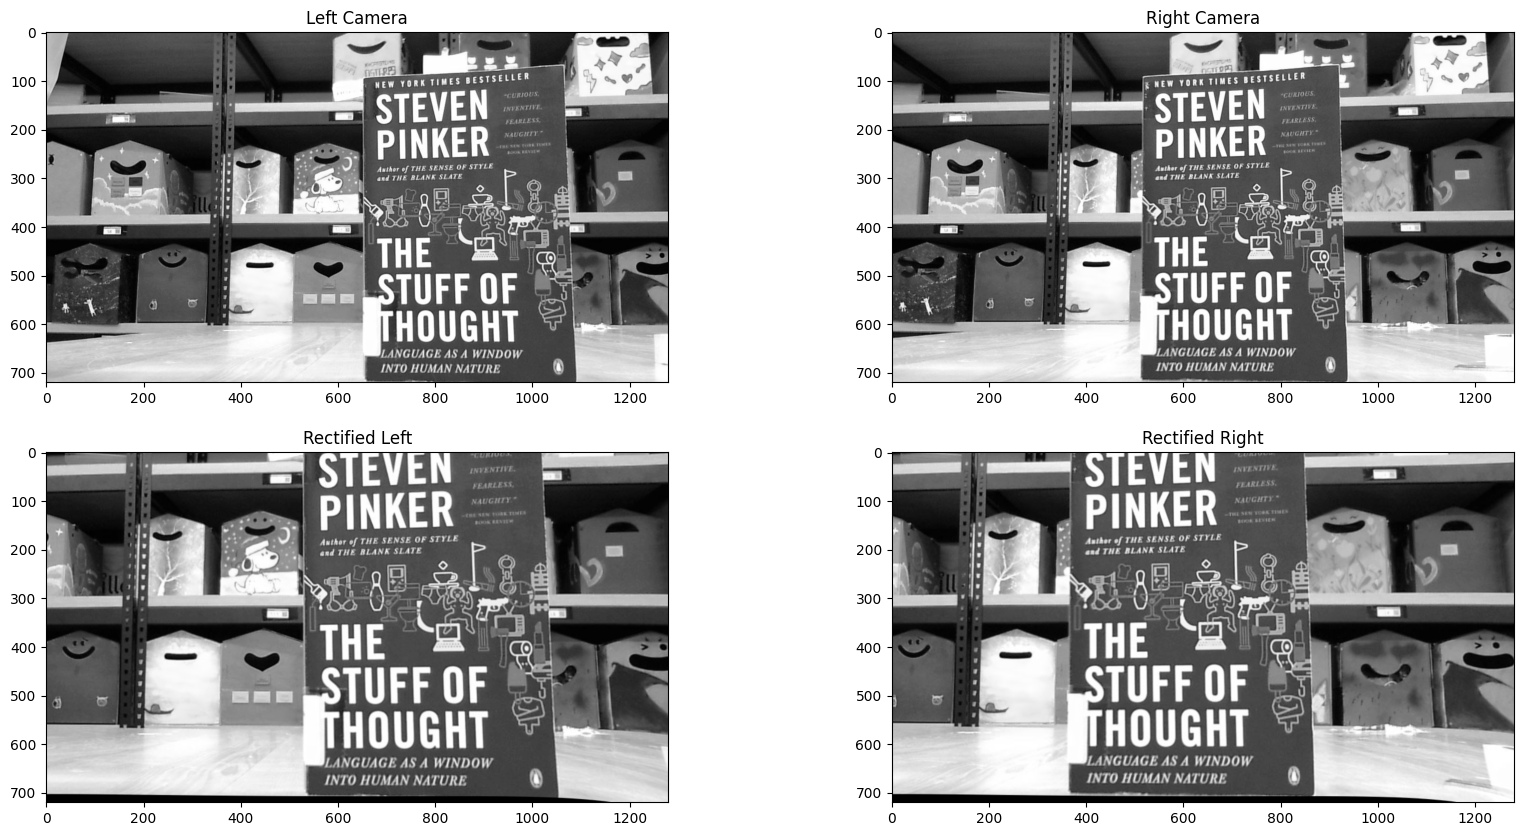

In [13]:
# Import images
imgL = cv.imread('assets/mono/position1/left.jpg')
imgR = cv.imread('assets/mono/position1/right.jpg')

# Params for stereo/mono. Set True if using stereo, else False.
stereo = False

# Convert to grayscale
gray_imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
gray_imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# Rectify
retification = rectify(imgL = gray_imgL, imgR = gray_imgR)
rec_imgL, rec_imgR = undistort(gray_imgL, gray_imgR, retification)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(gray_imgL, cmap = "gray"); ax.set_title('Left Camera')
ax = fig.add_subplot(2, 2, 2); plt.imshow(gray_imgR, cmap = "gray"); ax.set_title('Right Camera');
ax = fig.add_subplot(2, 2, 3); plt.imshow(rec_imgL, cmap = "gray"); ax.set_title('Rectified Left')
ax = fig.add_subplot(2, 2, 4); plt.imshow(rec_imgR, cmap = "gray"); ax.set_title('Rectified Right');

We can see that the points are quite aligned. However, the images are cropped as the result of undistortion.

### 2. Compute disparity map

Using the same codes as above, let's see the result.

Text(0.5, 1.0, 'Combination')

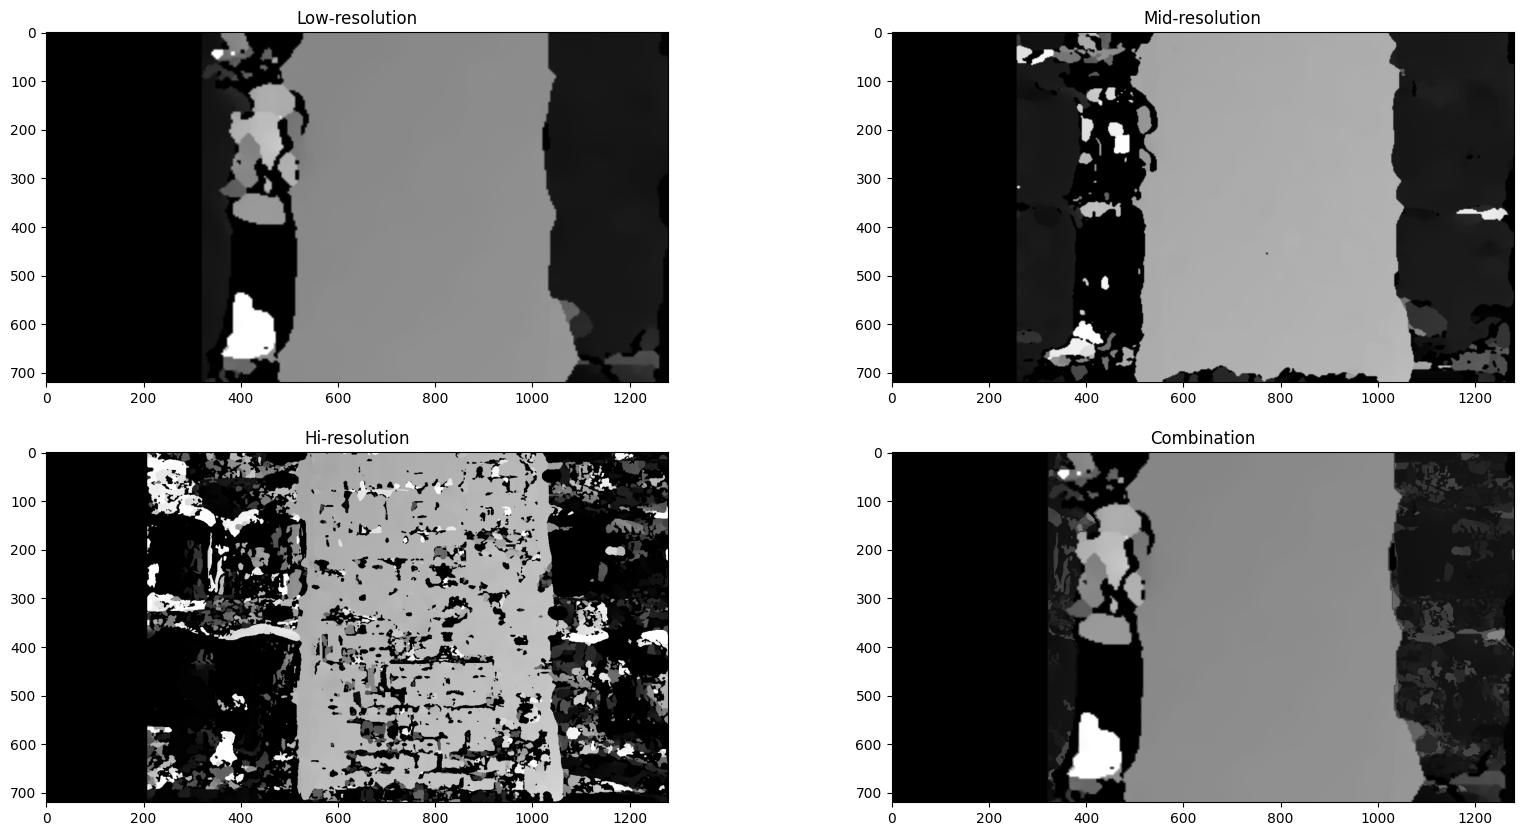

In [14]:
# Calculate disparity
hi, mid, low = return_disparity(rec_imgL, rec_imgR)

# Specify the dectected ranges
range_low = return_ranges(low, 0.25, 1.25, 10, 50000)
range_mid_high = merge_range(return_ranges(low, 0.05, 0.25, 2, 50000))

# Combine
combined = combine_disparity(gray_imgL.shape[::-1], low, mid, hi, range_mid_high)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(low, cmap = "gray"); ax.set_title('Low-resolution')
ax = fig.add_subplot(2, 2, 2); plt.imshow(mid, cmap = "gray"); ax.set_title('Mid-resolution')
ax = fig.add_subplot(2, 2, 3); plt.imshow(hi, cmap = "gray"); ax.set_title('Hi-resolution')
ax = fig.add_subplot(2, 2, 4); plt.imshow(combined, cmap = "gray"); ax.set_title('Combination')

And the result is as good as above.

### 3. Calculate and export depth map

We use slightly the same codes as above with only 1 modification. Instead of using the input image, we undistort it using above retification matrix to make sure that the depth map aligns with the input left image.

In [15]:
# Calculate depth map
depth_map = return_depth(combined, stereo)
new_img = undistort(imgL, imgR, retification)[0]  # This's just got added

# Compute point cloud
height, width = depth_map.shape
pcd = np.zeros((height, width, 3))

# Remove out-of-bound area
mask = cv.inRange(depth_map, 0, 200)
depth_safe = cv.bitwise_and(depth_map, depth_map, depth_map, mask = mask)

for i in range(height):
    for j in range(width):
        z = depth_safe[i][j]
        pcd[i][j] = [i, j, z]
        
_, data = depth_to_ply(new_img, pcd, name = "notebook_mono_pts")

The code write a new Point cloud file to [outputs/notebook_mono_pts.ply](outputs/notebook_mono_pts.ply) that you can open yourself to see the result. For demonstration purpose, I have screenshot the point cloud file at some angle and will show you as below:

<p float = "center">
    <img src="utils/img/PointCloud04.png" width = "320">
    <img src="utils/img/PointCloud05.png" width = "320">
    <img src="utils/img/PointCloud06.png" width = "320">
</p>

Althought the result is not good as above, it is still acceptable.

### 4. Show disparity, depth and display warning

Using the same codes as above, let's see the result.

Text(0.5, 1.0, 'Image')

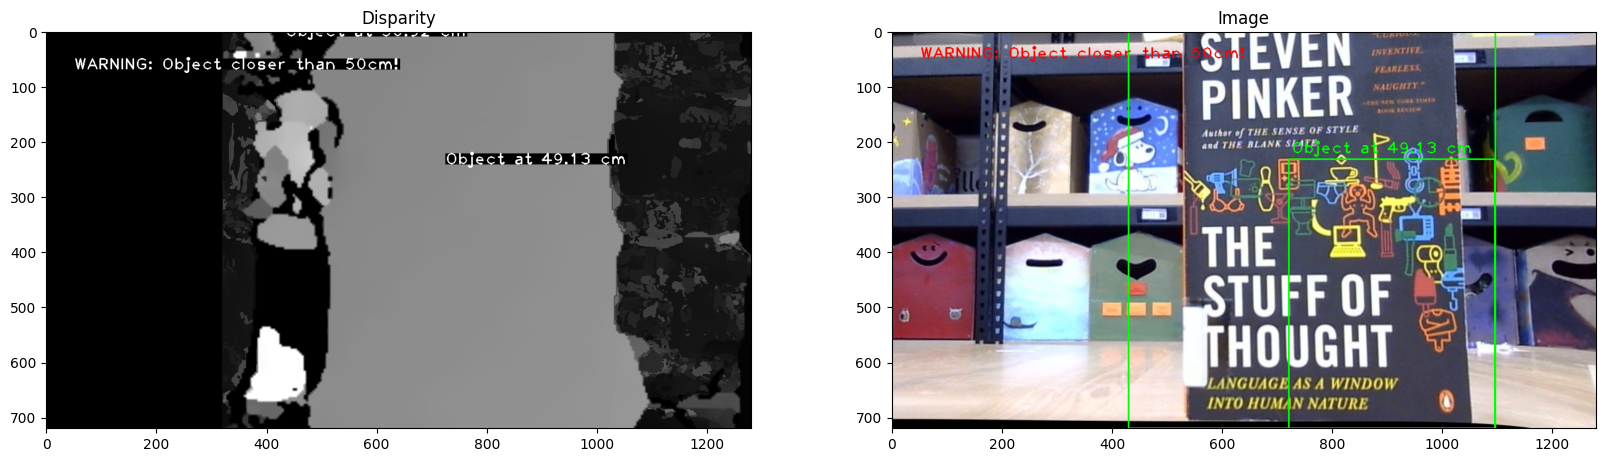

In [16]:
# Create canvas for visualization
canvas_dispar = normalize(combined)
canvas_img = new_img.copy()

# Show depth and warning text
for dispar_range in range_low:
    x_left, y_top, x_right, y_bot, value = display_individual_depth(combined, dispar_range, stereo)
    
    # Put text on disparity image
    draw_text(canvas_dispar, "Object at %.2f cm" % value, (x_left + 5, y_top - 10))
    
    # Put text and detected box on image imae
    cv.putText(canvas_img, "Object at %.2f cm" % value,
               (x_left + 5, y_top - 10), 1, 2, (0, 255, 0), 2, 2)
    cv.rectangle(canvas_img, (x_left, y_top), (x_right, y_bot), (0, 255, 0), 2)
    
    # Put warning text
    if value < 50:
        draw_text(canvas_dispar, "WARNING: Object closer than 50cm!", (50, 50))
        cv.putText(canvas_img, "WARNING: Object closer than 50cm!",
                   (50, 50), 1, 2, (0, 0, 255), 2, 2)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 2, 1); plt.imshow(canvas_dispar, cmap = "gray"); ax.set_title('Disparity')
ax = fig.add_subplot(1, 2, 2); plt.imshow(canvas_img[:, :, ::-1]); ax.set_title('Image')

As we measured in real-life, the distance is 50cm. With the detection of 49.13cm, the algorithm's result is also really close to the truth value (±1 error). Moreover, as we can see, the warning pops up, saying that "Object closer than 50cm!".

## C. Appendix

In this section, we will explore the capability of our program. Besides the good accuracy, our program can also detect multiple objects and calculate their depth correspondingly. We wrap the process as above into a method called `display_depth()` as follow.

In [17]:
def display_depth(imgL, imgR, stereo):
    # Convert to grayscale
    gray_imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    gray_imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    # Calculate disparity
    hi, mid, low = return_disparity(gray_imgL, gray_imgR)

    # Specify the dectected ranges
    range_low = return_ranges(low, 0.25, 1.25, 10, 50000)
    range_mid_high = merge_range(return_ranges(low, 0.05, 0.25, 2, 50000))

    # Combine disparity of different resolution
    combined = combine_disparity(gray_imgL.shape[::-1], low, mid, hi, range_mid_high)

    # Calculate depth map
    depth_map = return_depth(combined, stereo)

    # Create canvas for visualization
    canvas_dispar = normalize(combined)
    canvas_img = imgL.copy()

    # Show depth and warning text
    for dispar_range in range_low:
        x_left, y_top, x_right, y_bot, value = display_individual_depth(combined, dispar_range, stereo)

        # Put text on disparity image
        draw_text(canvas_dispar, "Object at %.2f cm" % value, (x_left + 5, y_top - 10))

        # Put text and detected box on image imae
        cv.putText(canvas_img, "Object at %.2f cm" % value,
                   (x_left + 5, y_top - 10), 1, 2, (0, 255, 0), 2, 2)
        cv.rectangle(canvas_img, (x_left, y_top), (x_right, y_bot), (0, 255, 0), 2)

        # Put warning text
        if value < 50:
            draw_text(canvas_dispar, "WARNING: Object closer than 50cm!", (50, 50))
            cv.putText(canvas_img, "WARNING: Object closer than 50cm!",
                       (50, 50), 1, 2, (0, 0, 255), 2, 2)

    # Display images
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1, 2, 1); plt.imshow(canvas_dispar, cmap = "gray"); ax.set_title('Disparity')
    ax = fig.add_subplot(1, 2, 2); plt.imshow(canvas_img[:, :, ::-1]); ax.set_title('Image')

Let's see its power.

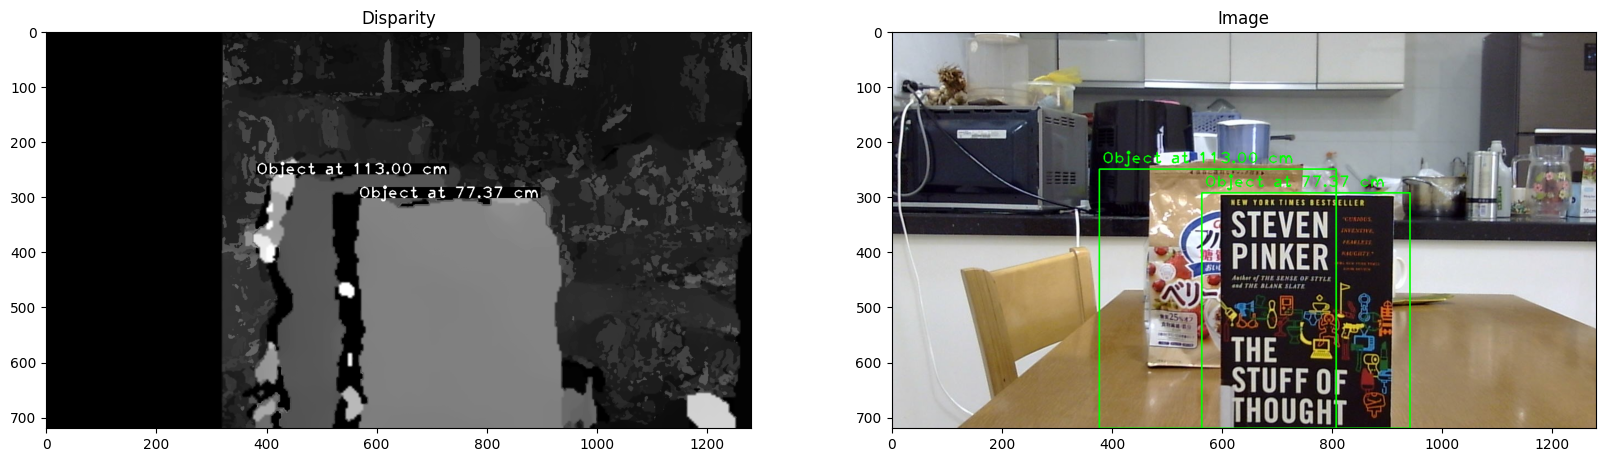

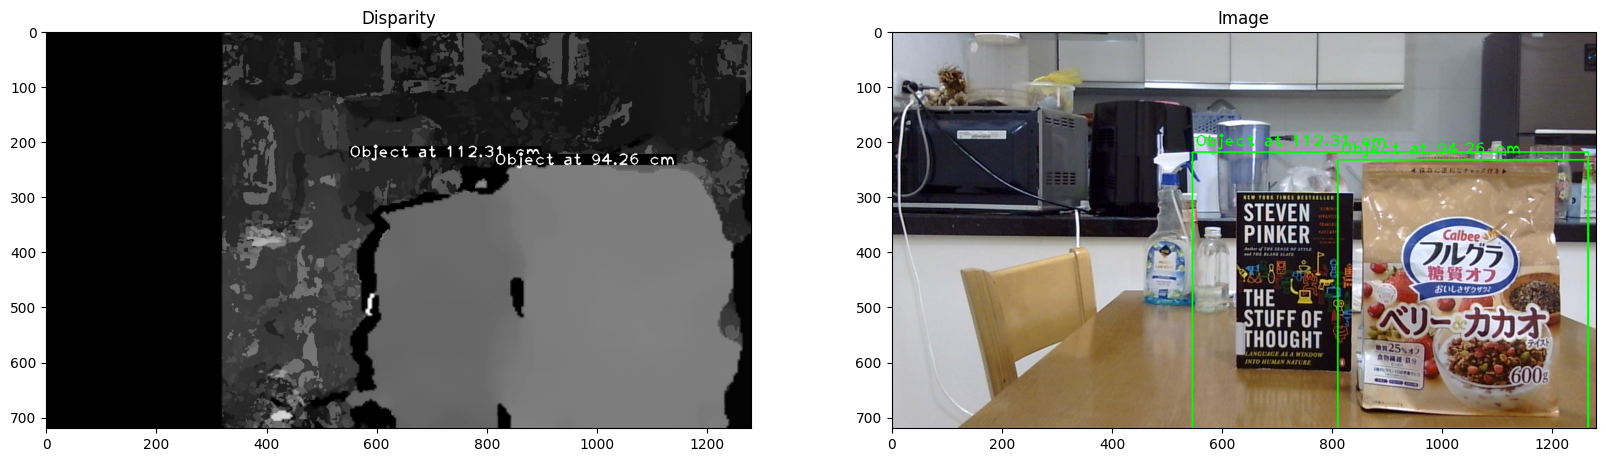

In [18]:
# Import images
imgL = cv.imread('assets/playground/position1/left.jpg')
imgR = cv.imread('assets/playground/position1/right.jpg')
display_depth(imgL, imgR, True)

# Import images
imgL = cv.imread('assets/playground/position2/left.jpg')
imgR = cv.imread('assets/playground/position2/right.jpg')
display_depth(imgL, imgR, True)